In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import matplotlib.pyplot as plt
import cv2
import torch
import shutil
from torchvision.ops import batched_nms
from PIL import Image

In [2]:
from PIL import Image
import os
n=0
image_folder = "/kaggle/input/traffic-dataset/traffic_wala_dataset/valid/images"
for filename in os.listdir(image_folder):
    file_path = os.path.join(image_folder, filename)

    try:
        with Image.open(file_path) as img:
            if img.mode == "RGB":
                n+=1
    except Exception as e:
        print(f"error, cant find")

print(n)


90


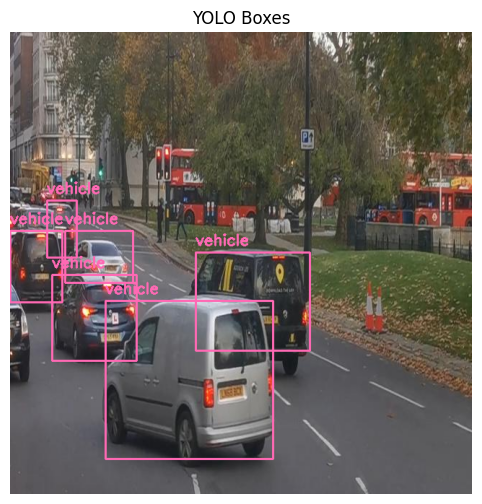

In [3]:
image_path = "/kaggle/input/traffic-dataset/traffic_wala_dataset/train/images/2_mp4-23_jpg.rf.9630295f3c98ec2ad851a859992d2527.jpg"
label_path = "/kaggle/input/traffic-dataset/traffic_wala_dataset/train/labels/2_mp4-23_jpg.rf.9630295f3c98ec2ad851a859992d2527.txt"

image = cv2.imread(image_path)
h, w = image.shape[:2]

class_names = ['vehicle']

with open(label_path, 'r') as f:
    for line in f:
        parts = line.strip().split()
        cls, x, y, bw, bh = map(float, parts)
        x1 = int((x - bw / 2) * w)
        y1 = int((y - bh / 2) * h)
        x2 = int((x + bw / 2) * w)
        y2 = int((y + bh / 2) * h)

        color = (180, 105, 255) 
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)

        if class_names:
            label = class_names[int(cls)]
            cv2.putText(image, label, (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 6))
plt.imshow(image_rgb)
plt.axis('off')
plt.title("YOLO Boxes")
plt.show()

In [5]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 26.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 5.1 MB/s eta 0:00:000:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existin

In [6]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [10]:
import yaml

yolo_data = {
    'train': '/kaggle/input/traffic-dataset/traffic_wala_dataset/train',
    'val': '/kaggle/input/traffic-dataset/traffic_wala_dataset/valid',
    'nc': 1,
    'names': ['vehicle']
}
with open('/kaggle/working/yolo_data.yaml', 'w') as f:
    yaml.dump(yolo_data, f)

print("✅ YOLO data.yaml created at /kaggle/working/yolo_data.yaml")



✅ YOLO data.yaml created at /kaggle/working/yolo_data.yaml


In [7]:
model = YOLO("yolo11n.yaml")
model = YOLO("yolo11n.pt")
model = YOLO("yolo11n.yaml").load("yolo11n.pt")

100%|██████████| 5.35M/5.35M [00:00<00:00, 153MB/s]


Transferred 499/499 items from pretrained weights


In [26]:
results = model.train(data="/kaggle/working/yolo_data.yaml", epochs=100, batch=16, imgsz=640, save = True,optimizer = "AdamW", seed = 42,cos_lr=True,amp=True,lr0=1e-3,momentum=0.555,warmup_epochs=5,dropout=0.3,val=True, project = '/kaggle/working/runs/detect',name ='run-1')

Ultralytics 8.3.155 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/kaggle/working/yolo_data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.3, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.yaml, momentum=0.555, mosaic=1.0, multi_scale=False, name=run-1, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pret

train: Scanning /kaggle/input/traffic-dataset/traffic_wala_dataset/train/labels... 536 images, 0 backgrounds, 0 corrupt: 100%|██████████| 536/536 [00:03<00:00, 161.03it/s]


WARNING ⚠️ train: Cache directory /kaggle/input/traffic-dataset/traffic_wala_dataset/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 2.3±1.2 ms, read: 46.8±4.4 MB/s, size: 51.4 KB)


val: Scanning /kaggle/input/traffic-dataset/traffic_wala_dataset/valid/labels... 90 images, 0 backgrounds, 0 corrupt: 100%|██████████| 90/90 [00:00<00:00, 425.59it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/traffic-dataset/traffic_wala_dataset/valid is not writeable, cache not saved.


Plotting labels to /kaggle/working/runs/detect/run-1/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.555) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /kaggle/working/runs/detect/run-1
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100       2.8G      1.275      1.635      1.074        116        640: 100%|██████████| 34/34 [00:08<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.88it/s]

                   all         90        937     0.0314      0.905        0.7      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.82G      1.196     0.9122      1.038        206        640: 100%|██████████| 34/34 [00:05<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.62it/s]


                   all         90        937      0.274      0.977      0.846      0.567

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.84G       1.19     0.8439      1.031        135        640: 100%|██████████| 34/34 [00:05<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.02it/s]

                   all         90        937      0.899      0.644      0.888      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.86G      1.169     0.7949      1.021         85        640: 100%|██████████| 34/34 [00:05<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.53it/s]

                   all         90        937      0.812      0.866      0.902      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.87G      1.174     0.7779      1.025        210        640: 100%|██████████| 34/34 [00:05<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.57it/s]

                   all         90        937      0.857      0.884      0.931      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.89G      1.169     0.7513      1.015         75        640: 100%|██████████| 34/34 [00:05<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.43it/s]


                   all         90        937      0.888      0.875      0.945      0.661

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100       2.9G      1.138     0.7345       1.02         94        640: 100%|██████████| 34/34 [00:05<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.84it/s]

                   all         90        937      0.868      0.915      0.951      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.92G      1.168     0.7719      1.028        116        640: 100%|██████████| 34/34 [00:05<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.28it/s]


                   all         90        937      0.833      0.886      0.936      0.638

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.93G      1.116      0.693     0.9954        161        640: 100%|██████████| 34/34 [00:05<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.73it/s]

                   all         90        937      0.875      0.911      0.954      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.95G      1.113     0.7075      1.007        125        640: 100%|██████████| 34/34 [00:05<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.55it/s]

                   all         90        937       0.87      0.905       0.95      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.96G      1.125     0.6787      1.006        113        640: 100%|██████████| 34/34 [00:05<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.36it/s]

                   all         90        937      0.903      0.886       0.96      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.98G      1.105     0.6803      1.002         81        640: 100%|██████████| 34/34 [00:05<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.51it/s]

                   all         90        937      0.881      0.908      0.956      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.99G      1.091     0.6459     0.9917         87        640: 100%|██████████| 34/34 [00:05<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.80it/s]

                   all         90        937       0.89       0.91      0.956      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      3.01G      1.068     0.6277     0.9811        210        640: 100%|██████████| 34/34 [00:05<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.86it/s]

                   all         90        937      0.902      0.896      0.962      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      3.02G      1.072     0.6452     0.9918         89        640: 100%|██████████| 34/34 [00:05<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.91it/s]

                   all         90        937      0.896      0.886      0.956      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      3.04G      1.064     0.6331      0.985        114        640: 100%|██████████| 34/34 [00:05<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.85it/s]

                   all         90        937      0.914      0.896      0.963      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      3.05G      1.067     0.6263     0.9857        109        640: 100%|██████████| 34/34 [00:05<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.59it/s]

                   all         90        937      0.874      0.937      0.964       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      3.06G      1.054     0.6081     0.9758        101        640: 100%|██████████| 34/34 [00:05<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.00it/s]

                   all         90        937      0.905      0.907      0.967      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      3.08G      1.024     0.6045     0.9746         73        640: 100%|██████████| 34/34 [00:05<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.62it/s]

                   all         90        937      0.846      0.924      0.951       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      3.09G      1.054     0.6022     0.9861         92        640: 100%|██████████| 34/34 [00:05<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.76it/s]

                   all         90        937      0.891      0.904      0.957      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      3.11G      1.025     0.5812     0.9673        179        640: 100%|██████████| 34/34 [00:05<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.86it/s]

                   all         90        937      0.896      0.914      0.954      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      3.12G      1.014     0.5812     0.9638        126        640: 100%|██████████| 34/34 [00:05<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.25it/s]

                   all         90        937      0.868       0.92      0.951       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      3.14G      1.026     0.6021     0.9741         81        640: 100%|██████████| 34/34 [00:05<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.71it/s]

                   all         90        937      0.886      0.933      0.962      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      3.15G      1.032     0.5834     0.9738        114        640: 100%|██████████| 34/34 [00:05<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.86it/s]

                   all         90        937      0.904      0.904      0.961       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      3.17G      1.007     0.5814     0.9606        100        640: 100%|██████████| 34/34 [00:05<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.95it/s]

                   all         90        937      0.892      0.907      0.958      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      3.18G      1.014     0.5727     0.9698        115        640: 100%|██████████| 34/34 [00:05<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.76it/s]

                   all         90        937      0.915      0.886      0.953      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100       3.2G      1.014     0.5794      0.964         97        640: 100%|██████████| 34/34 [00:05<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.92it/s]

                   all         90        937      0.911      0.909       0.96      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      3.21G      0.995     0.5635     0.9521         79        640: 100%|██████████| 34/34 [00:05<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.86it/s]

                   all         90        937      0.923      0.894      0.965      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      3.23G     0.9998     0.5788     0.9636        125        640: 100%|██████████| 34/34 [00:05<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.61it/s]

                   all         90        937      0.897      0.911      0.964      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      3.24G      1.011     0.5598     0.9558        170        640: 100%|██████████| 34/34 [00:05<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.69it/s]

                   all         90        937      0.895      0.914      0.966      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      3.26G      0.987     0.5541     0.9559        129        640: 100%|██████████| 34/34 [00:05<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.88it/s]

                   all         90        937      0.912      0.913      0.969      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      3.27G      0.985      0.546     0.9508         78        640: 100%|██████████| 34/34 [00:05<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.95it/s]

                   all         90        937      0.897      0.914      0.959      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      3.29G     0.9618     0.5434     0.9421        111        640: 100%|██████████| 34/34 [00:05<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.71it/s]

                   all         90        937      0.907      0.921      0.963       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100       3.3G     0.9629     0.5385     0.9473        139        640: 100%|██████████| 34/34 [00:05<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.96it/s]

                   all         90        937      0.893      0.934      0.967      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      3.32G     0.9691     0.5278     0.9432         87        640: 100%|██████████| 34/34 [00:05<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.87it/s]

                   all         90        937       0.91      0.922      0.963      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      3.33G      0.971     0.5286     0.9485         96        640: 100%|██████████| 34/34 [00:05<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.29it/s]

                   all         90        937      0.896      0.925      0.961      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      3.35G     0.9659      0.527     0.9447        104        640: 100%|██████████| 34/34 [00:05<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.68it/s]

                   all         90        937      0.913      0.917       0.96      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      3.36G     0.9481     0.5285     0.9458        172        640: 100%|██████████| 34/34 [00:05<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.63it/s]

                   all         90        937      0.927      0.907      0.975      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      3.38G     0.9544       0.52      0.944        144        640: 100%|██████████| 34/34 [00:05<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.88it/s]

                   all         90        937       0.91      0.915      0.968      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      3.39G     0.9386     0.5182     0.9325        100        640: 100%|██████████| 34/34 [00:05<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.95it/s]

                   all         90        937      0.908      0.918      0.966      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100       3.4G     0.9509     0.5221     0.9483        105        640: 100%|██████████| 34/34 [00:05<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.07it/s]

                   all         90        937      0.903      0.931       0.97      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      3.42G     0.9484     0.5288     0.9405         77        640: 100%|██████████| 34/34 [00:05<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.60it/s]

                   all         90        937      0.889      0.904       0.95       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      3.44G     0.9537       0.52     0.9488        126        640: 100%|██████████| 34/34 [00:05<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.92it/s]

                   all         90        937       0.92      0.914      0.969      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      3.45G     0.9327     0.5109     0.9362        117        640: 100%|██████████| 34/34 [00:05<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.76it/s]

                   all         90        937      0.905      0.934      0.964      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      3.46G     0.9225     0.5082     0.9312        117        640: 100%|██████████| 34/34 [00:05<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.80it/s]


                   all         90        937      0.918      0.932      0.967       0.72

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      3.48G     0.9104     0.4995      0.937        133        640: 100%|██████████| 34/34 [00:05<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.78it/s]

                   all         90        937      0.903      0.942      0.969      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      3.49G     0.9205     0.5018     0.9327        214        640: 100%|██████████| 34/34 [00:05<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.73it/s]

                   all         90        937      0.931      0.908      0.968      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      3.51G     0.9188     0.4988      0.931        112        640: 100%|██████████| 34/34 [00:05<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.54it/s]

                   all         90        937      0.923      0.911       0.97      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      3.52G     0.9171     0.4998     0.9379         90        640: 100%|██████████| 34/34 [00:05<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.81it/s]

                   all         90        937      0.908      0.927      0.971      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      3.54G     0.9112     0.4947      0.931        116        640: 100%|██████████| 34/34 [00:05<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.60it/s]

                   all         90        937       0.93      0.922      0.973      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      3.55G     0.8983     0.4992     0.9318         30        640: 100%|██████████| 34/34 [00:05<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.73it/s]

                   all         90        937      0.916       0.91      0.962      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      3.75G     0.8999     0.4867     0.9285        111        640: 100%|██████████| 34/34 [00:05<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.88it/s]

                   all         90        937      0.909      0.943      0.969      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      3.77G     0.8997     0.4886     0.9275        147        640: 100%|██████████| 34/34 [00:05<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.90it/s]

                   all         90        937      0.904      0.938      0.967      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      3.78G     0.9039     0.4834     0.9275        193        640: 100%|██████████| 34/34 [00:05<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.90it/s]

                   all         90        937       0.92      0.926      0.972      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100       3.8G     0.8846     0.4763     0.9212        146        640: 100%|██████████| 34/34 [00:05<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.71it/s]

                   all         90        937      0.914      0.925      0.971       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      3.81G     0.8889     0.4811     0.9281        133        640: 100%|██████████| 34/34 [00:05<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.96it/s]

                   all         90        937      0.939      0.908      0.969      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      3.83G     0.8866     0.4749     0.9297         65        640: 100%|██████████| 34/34 [00:05<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.16it/s]

                   all         90        937      0.903      0.925      0.969      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      3.84G     0.8824     0.4766     0.9181        155        640: 100%|██████████| 34/34 [00:05<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.53it/s]

                   all         90        937      0.885      0.927      0.962      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      3.86G     0.8896     0.4775     0.9229        101        640: 100%|██████████| 34/34 [00:05<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.88it/s]

                   all         90        937      0.911      0.931      0.963      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      3.87G     0.8753     0.4713      0.925         77        640: 100%|██████████| 34/34 [00:05<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.23it/s]

                   all         90        937      0.918      0.933       0.96      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      3.88G     0.8704     0.4643     0.9186        135        640: 100%|██████████| 34/34 [00:05<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.01it/s]

                   all         90        937      0.903      0.943      0.968       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100       3.9G     0.8728     0.4596     0.9205         93        640: 100%|██████████| 34/34 [00:05<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.92it/s]

                   all         90        937      0.931      0.917       0.97      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      3.91G     0.8659     0.4613     0.9194        110        640: 100%|██████████| 34/34 [00:05<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.92it/s]

                   all         90        937      0.901      0.931      0.969      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      3.93G     0.8496     0.4494      0.909        195        640: 100%|██████████| 34/34 [00:05<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.56it/s]

                   all         90        937      0.908      0.934      0.971      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      3.94G     0.8678     0.4554     0.9185         90        640: 100%|██████████| 34/34 [00:05<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.71it/s]

                   all         90        937      0.903      0.939      0.967      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      3.96G       0.85     0.4563     0.9093        125        640: 100%|██████████| 34/34 [00:05<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.12it/s]

                   all         90        937      0.915      0.932      0.967       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      3.97G     0.8468     0.4404     0.9085        122        640: 100%|██████████| 34/34 [00:05<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.56it/s]

                   all         90        937      0.924      0.921      0.965       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      3.99G     0.8413     0.4403     0.9125        100        640: 100%|██████████| 34/34 [00:05<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.78it/s]

                   all         90        937      0.899       0.95      0.967      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100         4G     0.8521     0.4507     0.9139        107        640: 100%|██████████| 34/34 [00:05<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.75it/s]

                   all         90        937       0.91      0.935      0.963       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      4.02G     0.8308     0.4477     0.9051        135        640: 100%|██████████| 34/34 [00:05<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.82it/s]

                   all         90        937      0.909      0.934      0.968      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      4.03G     0.8531     0.4435     0.9128        113        640: 100%|██████████| 34/34 [00:05<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.88it/s]

                   all         90        937      0.909       0.94       0.97      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      4.05G     0.8362     0.4404     0.9084        133        640: 100%|██████████| 34/34 [00:05<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.50it/s]

                   all         90        937       0.91       0.93      0.966      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      4.06G     0.8239     0.4367     0.9019        164        640: 100%|██████████| 34/34 [00:05<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.98it/s]

                   all         90        937      0.917      0.931      0.965      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      4.08G     0.8255     0.4316     0.9055         89        640: 100%|██████████| 34/34 [00:05<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.79it/s]

                   all         90        937      0.922       0.92      0.965      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      4.09G     0.8247     0.4359     0.9048        103        640: 100%|██████████| 34/34 [00:05<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.76it/s]

                   all         90        937      0.925      0.917      0.964      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      4.11G     0.8217     0.4421     0.9022        102        640: 100%|██████████| 34/34 [00:05<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.96it/s]

                   all         90        937      0.926      0.916      0.967      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      4.12G     0.8142      0.428      0.906         83        640: 100%|██████████| 34/34 [00:05<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.91it/s]

                   all         90        937      0.914      0.925      0.965      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      4.14G     0.8177     0.4302     0.9028        106        640: 100%|██████████| 34/34 [00:05<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.67it/s]

                   all         90        937        0.9      0.931      0.961      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      4.15G     0.8092      0.423     0.9009        105        640: 100%|██████████| 34/34 [00:05<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.42it/s]

                   all         90        937      0.915      0.935      0.961      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      4.17G     0.8066     0.4285     0.9015        107        640: 100%|██████████| 34/34 [00:05<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.91it/s]

                   all         90        937      0.909      0.941      0.965       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      4.18G     0.7985     0.4225     0.8997        110        640: 100%|██████████| 34/34 [00:05<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.69it/s]

                   all         90        937      0.921      0.934      0.966      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100       4.2G     0.8076     0.4293     0.9026         96        640: 100%|██████████| 34/34 [00:05<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.75it/s]

                   all         90        937      0.912      0.936      0.967      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      4.21G     0.8009     0.4258     0.9014        126        640: 100%|██████████| 34/34 [00:05<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.73it/s]

                   all         90        937      0.915      0.933      0.965      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      4.22G     0.8078     0.4209     0.9038         93        640: 100%|██████████| 34/34 [00:05<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.69it/s]

                   all         90        937      0.898      0.941      0.965      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      4.24G     0.7985     0.4193     0.8935        156        640: 100%|██████████| 34/34 [00:05<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.93it/s]

                   all         90        937      0.923      0.918      0.964       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      4.25G     0.7917     0.4106     0.8942        136        640: 100%|██████████| 34/34 [00:05<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.73it/s]

                   all         90        937      0.912      0.927      0.965      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      4.27G     0.7925     0.4163     0.8945        116        640: 100%|██████████| 34/34 [00:05<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.06it/s]

                   all         90        937      0.923      0.923      0.963      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      4.29G     0.7872      0.417     0.8947        125        640: 100%|██████████| 34/34 [00:05<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.96it/s]

                   all         90        937      0.909      0.937      0.965      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100       4.3G     0.7868     0.4121     0.8902        116        640: 100%|██████████| 34/34 [00:05<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.92it/s]

                   all         90        937      0.925      0.914      0.964      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      4.31G     0.7927      0.415     0.8972        140        640: 100%|██████████| 34/34 [00:05<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.75it/s]

                   all         90        937      0.917      0.928      0.964       0.73


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      4.33G     0.7723      0.396      0.898         95        640: 100%|██████████| 34/34 [00:06<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.89it/s]

                   all         90        937      0.922      0.928      0.961      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      4.34G     0.7748     0.3922     0.8909         83        640: 100%|██████████| 34/34 [00:05<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.94it/s]

                   all         90        937      0.917      0.928      0.962      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      4.36G     0.7665     0.3932     0.9027         88        640: 100%|██████████| 34/34 [00:05<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.96it/s]

                   all         90        937      0.913      0.929      0.962      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      4.37G      0.763     0.3877      0.893         75        640: 100%|██████████| 34/34 [00:05<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.07it/s]

                   all         90        937      0.901      0.943      0.962      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      4.39G     0.7509     0.3852      0.884         68        640: 100%|██████████| 34/34 [00:05<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.93it/s]

                   all         90        937      0.903      0.939      0.962      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100       4.4G     0.7619     0.3872      0.895         62        640: 100%|██████████| 34/34 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.85it/s]

                   all         90        937      0.908      0.937      0.962      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      4.42G     0.7611     0.3855     0.8889         71        640: 100%|██████████| 34/34 [00:05<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.06it/s]

                   all         90        937      0.907       0.94      0.962      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      4.43G     0.7593     0.3865     0.8898         59        640: 100%|██████████| 34/34 [00:05<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.06it/s]

                   all         90        937      0.907      0.937      0.963      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      4.45G     0.7559     0.3791     0.8889        130        640: 100%|██████████| 34/34 [00:05<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.83it/s]

                   all         90        937      0.907      0.937      0.962      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      4.46G     0.7631     0.3903     0.8888         91        640: 100%|██████████| 34/34 [00:05<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.99it/s]

                   all         90        937      0.902      0.942      0.962      0.727



100 epochs completed in 0.189 hours.
Optimizer stripped from /kaggle/working/runs/detect/run-1/weights/last.pt, 5.5MB
Optimizer stripped from /kaggle/working/runs/detect/run-1/weights/best.pt, 5.5MB

Validating /kaggle/working/runs/detect/run-1/weights/best.pt...
Ultralytics 8.3.155 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.49it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         90        937      0.931      0.916       0.97      0.738
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to /kaggle/working/runs/detect/run-1


In [ ]:
results = model('/kaggle/input/traffic-dataset/traffic_wala_dataset/valid/images', save=True, save_txt=True, save_conf=True)

In [28]:
metrics = model.val(
    data='/kaggle/working/yolo_data.yaml',
    imgsz=640,
    batch=16,
    save=True,    \
    save_txt=True, 
    save_conf=True
)

Ultralytics 8.3.155 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 2.2±0.4 ms, read: 51.9±7.5 MB/s, size: 66.3 KB)


val: Scanning /kaggle/input/traffic-dataset/traffic_wala_dataset/valid/labels... 90 images, 0 backgrounds, 0 corrupt: 100%|██████████| 90/90 [00:00<00:00, 347.83it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/traffic-dataset/traffic_wala_dataset/valid is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.54it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         90        937      0.931      0.917       0.97      0.739
Speed: 3.7ms preprocess, 13.0ms inference, 0.0ms loss, 5.0ms postprocess per image
Results saved to /kaggle/working/runs/detect/run-12


***RUNNING MODEL WITH BEST WEIGHTS ON VALIDATION SET WITH IOU=1 TO DISABLE NON MAX SUPRRESION***

In [11]:
from ultralytics import YOLO

model_for_val = YOLO('/kaggle/input/best-weights/best.pt')  

metrics = model_for_val.val(
    data='/kaggle/working/yolo_data.yaml',  
    imgsz=640,                  
    batch=16,                      
    save=True,                     
    save_txt=True,                 
    save_conf=True,
    iou=1
)


Ultralytics 8.3.156 🚀 Python-3.11.11 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


100%|██████████| 755k/755k [00:00<00:00, 33.9MB/s]

val: Fast image access ✅ (ping: 0.5±0.0 ms, read: 14.1±3.6 MB/s, size: 52.3 KB)



val: Scanning /kaggle/input/traffic-dataset/traffic_wala_dataset/valid/labels... 90 images, 0 backgrounds, 0 corrupt: 100%|██████████| 90/90 [00:00<00:00, 344.94it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/traffic-dataset/traffic_wala_dataset/valid is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:23<00:00,  3.84s/it]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         90        937      0.215      0.598      0.308      0.245
Speed: 7.1ms preprocess, 197.9ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/val2


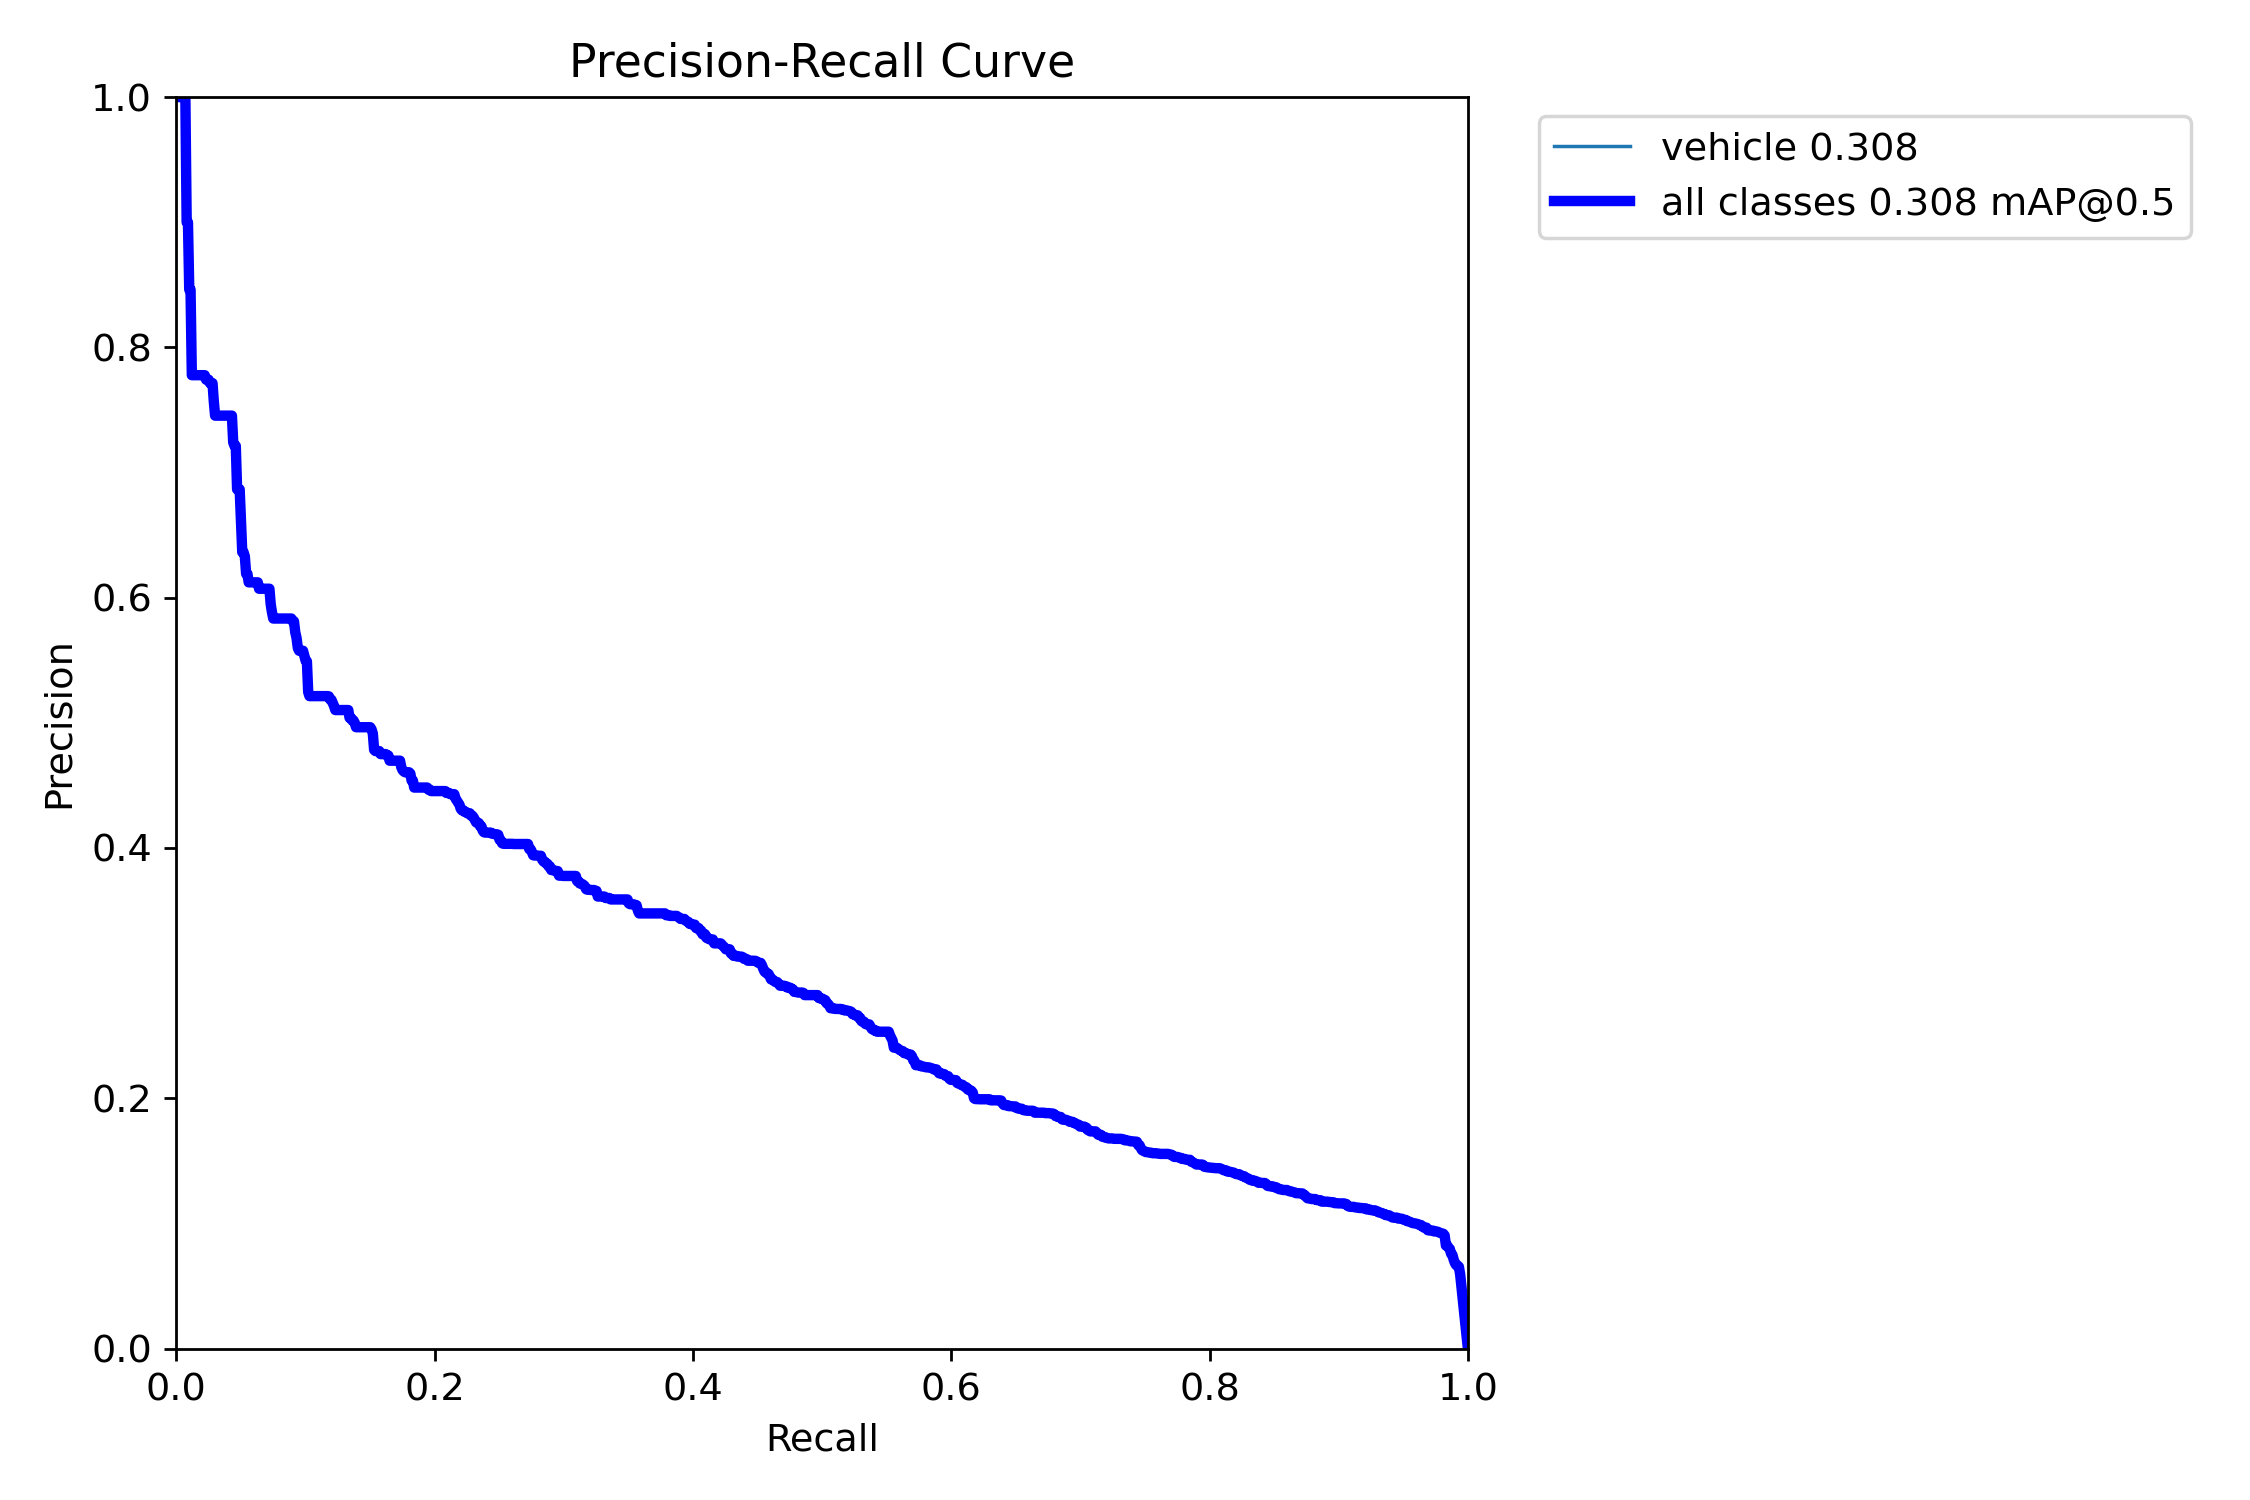

In [14]:
Image.open('/kaggle/working/runs/detect/val2/PR_curve.png')

large number of vehicles detected without any suppression and stored as raw predictions

In [16]:
val_results = model_for_val('/kaggle/input/traffic-dataset/traffic_wala_dataset/valid/images', save=True, conf=0.1,iou=1)
# frame = val_results[0].plot
# annotated_frame = val_results[0].plot()

# # Print bounding boxes and IDs (if available)
# for box in val_results[0].boxes:
#     bbox = box.xyxy
#     print("BBox:", bbox, "ID:", getattr(box, 'id', None))

# # Convert BGR to RGB for matplotlib
# annotated_frame_rgb = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)

# # Display image using matplotlib (Kaggle compatible)
# plt.figure(figsize=(12, 8))
# plt.imshow(annotated_frame_rgb)
# plt.title("YOLOv12 Vehicle Counting Result")
# plt.axis("off")
# plt.show()


image 1/90 /kaggle/input/traffic-dataset/traffic_wala_dataset/valid/images/10_mp4-0_jpg.rf.08b3bd34bbb73fb80c2d662c34474a98.jpg: 640x640 244 vehicles, 149.6ms
image 2/90 /kaggle/input/traffic-dataset/traffic_wala_dataset/valid/images/10_mp4-13_jpg.rf.aff71e875ee297d3086b715b7d6aaf26.jpg: 640x640 276 vehicles, 160.0ms
image 3/90 /kaggle/input/traffic-dataset/traffic_wala_dataset/valid/images/10_mp4-16_jpg.rf.b01cbf556a5a2c4154322deda0339880.jpg: 640x640 286 vehicles, 161.9ms
image 4/90 /kaggle/input/traffic-dataset/traffic_wala_dataset/valid/images/10_mp4-23_jpg.rf.13b084ba8417c6d0aaf5d4c35ddba6ac.jpg: 640x640 300 vehicles, 159.2ms
image 5/90 /kaggle/input/traffic-dataset/traffic_wala_dataset/valid/images/10_mp4-25_jpg.rf.11c919cc683cc6a0d0a658be13483748.jpg: 640x640 300 vehicles, 162.9ms
image 6/90 /kaggle/input/traffic-dataset/traffic_wala_dataset/valid/images/10_mp4-31_jpg.rf.0daa09b648954e3a19824a49ad49876e.jpg: 640x640 300 vehicles, 157.6ms
image 7/90 /kaggle/input/traffic-dataset

In [18]:
print(f"mAP@0.5: {metrics.box.map50:.4f}")

mAP@0.5: 0.3083


In [19]:
print(f"mAP@0.5:0.95: {metrics.box.map75:.4f}")

mAP@0.5:0.95: 0.3015


**DEFINING SOFT NON MAX FUNCTION**

In [20]:
import numpy as np

def soft_nms(boxes, scores, iou_thresh=0.3, sigma=0.5, score_thresh=0.15):
    boxes = np.array(boxes)
    scores = np.array(scores)
    N = boxes.shape[0]
    for i in range(N):
        maxpos = i + np.argmax(scores[i:])
        boxes[[i, maxpos]] = boxes[[maxpos, i]]
        scores[[i, maxpos]] = scores[[maxpos, i]]

        boxA = boxes[i]
        for j in range(i+1, N):
            boxB = boxes[j]
            xx1 = max(boxA[0], boxB[0])
            yy1 = max(boxA[1], boxB[1])
            xx2 = min(boxA[2], boxB[2])
            yy2 = min(boxA[3], boxB[3])
            w = max(0., xx2 - xx1 + 1)
            h = max(0., yy2 - yy1 + 1)
            inter = w * h
            areaA = (boxA[2]-boxA[0]+1) * (boxA[3]-boxA[1]+1)
            areaB = (boxB[2]-boxB[0]+1) * (boxB[3]-boxB[1]+1)
            iou = inter / (areaA + areaB - inter)
            
            weight = np.exp(- (iou ** 2) / sigma)
            scores[j] = scores[j] * weight
    keep = scores > score_thresh
    return boxes[keep], scores[keep]


In [21]:
for result in val_results:
    if result.boxes is not None:
        b = result.boxes.xyxy.cpu().numpy()
        s = result.boxes.conf.cpu().numpy()
        filtered_boxes, filtered_scores = soft_nms(b, s)
        print(f"Soft-NMS: {len(filtered_boxes)} detections kept")

Soft-NMS: 24 detections kept
Soft-NMS: 29 detections kept
Soft-NMS: 29 detections kept
Soft-NMS: 32 detections kept
Soft-NMS: 32 detections kept
Soft-NMS: 32 detections kept
Soft-NMS: 34 detections kept
Soft-NMS: 33 detections kept
Soft-NMS: 33 detections kept
Soft-NMS: 26 detections kept
Soft-NMS: 13 detections kept
Soft-NMS: 12 detections kept
Soft-NMS: 13 detections kept
Soft-NMS: 12 detections kept
Soft-NMS: 14 detections kept
Soft-NMS: 15 detections kept
Soft-NMS: 3 detections kept
Soft-NMS: 3 detections kept
Soft-NMS: 3 detections kept
Soft-NMS: 4 detections kept
Soft-NMS: 4 detections kept
Soft-NMS: 5 detections kept
Soft-NMS: 7 detections kept
Soft-NMS: 8 detections kept
Soft-NMS: 7 detections kept
Soft-NMS: 6 detections kept
Soft-NMS: 8 detections kept
Soft-NMS: 6 detections kept
Soft-NMS: 10 detections kept
Soft-NMS: 6 detections kept
Soft-NMS: 9 detections kept
Soft-NMS: 8 detections kept
Soft-NMS: 7 detections kept
Soft-NMS: 4 detections kept
Soft-NMS: 3 detections kept
Sof

In [22]:
output_folder = "/kaggle/working/softnms_output"
os.makedirs(output_folder, exist_ok=True)

In [23]:
import cv2
for i, result in enumerate(val_results):
    if result.boxes is not None:
        b = result.boxes.xyxy.cpu().numpy()
        s = result.boxes.conf.cpu().numpy()
        c = result.boxes.cls.cpu().numpy()
        filtered_boxes, filtered_scores = soft_nms(b, s)
        img_path = result.path
        img = cv2.imread(img_path)
        img_name_list= img_path.split('/')
        img_name=img_name_list[-1]
        for box, score in zip(filtered_boxes, filtered_scores):
            if score<0.05:
                continue
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)
            cv2.putText(img, f"{score:.2f}", (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)
        save_path = f"/kaggle/working/softnms_output/{img_name}"
        cv2.imwrite(save_path, img)

        print(f"Saved: {save_path}")


Saved: /kaggle/working/softnms_output/10_mp4-0_jpg.rf.08b3bd34bbb73fb80c2d662c34474a98.jpg
Saved: /kaggle/working/softnms_output/10_mp4-13_jpg.rf.aff71e875ee297d3086b715b7d6aaf26.jpg
Saved: /kaggle/working/softnms_output/10_mp4-16_jpg.rf.b01cbf556a5a2c4154322deda0339880.jpg
Saved: /kaggle/working/softnms_output/10_mp4-23_jpg.rf.13b084ba8417c6d0aaf5d4c35ddba6ac.jpg
Saved: /kaggle/working/softnms_output/10_mp4-25_jpg.rf.11c919cc683cc6a0d0a658be13483748.jpg
Saved: /kaggle/working/softnms_output/10_mp4-31_jpg.rf.0daa09b648954e3a19824a49ad49876e.jpg
Saved: /kaggle/working/softnms_output/10_mp4-35_jpg.rf.5de759e599ee930d33ec127e04347f97.jpg
Saved: /kaggle/working/softnms_output/10_mp4-39_jpg.rf.af70092b5f2277f16d2703a4d59c3313.jpg
Saved: /kaggle/working/softnms_output/10_mp4-46_jpg.rf.6f582e01a1a77c50f2716ac606abe4fe.jpg
Saved: /kaggle/working/softnms_output/10_mp4-9_jpg.rf.72a35ba2f76343afc7a101e720dbbb81.jpg
Saved: /kaggle/working/softnms_output/11_mp4-15_jpg.rf.b1bdb8b4864b5bed3c78f1a70e2

In [137]:
# import glob
# image_paths = sorted(glob.glob("/kaggle/working/softnms_outputs"))

In [187]:
# import shutil
# import os

# folder_path = "/kaggle/working/softnms_outputs_txt"

# if os.path.exists(folder_path):
#     shutil.rmtree(folder_path)
#     print(f"🗑️ Folder deleted: {folder_path}")
# else:
#     print(f"⚠️ Folder does not exist: {folder_path}")


🗑️ Folder deleted: /kaggle/working/softnms_outputs_txt


In [190]:
print(image_paths)

['/kaggle/working/softnms_outputs']


**SAVING SOFT NMS OUTPUT BOUNDING BOXES AS TEXT FILES WHILE SORTING ORDER OF BOXES FOUND TO HELP MATCH WITH GROUND TRUTH IN MAP CALCULATION**

In [25]:
output_txt_dir = "/kaggle/working/softnms_outputs_txt"
os.makedirs(output_txt_dir, exist_ok=True)
for i,result in enumerate(val_results):
    boxes = result.boxes.xyxy.cpu().numpy()
    scores = result.boxes.conf.cpu().numpy()
    classes = result.boxes.cls.cpu().numpy()

    original_idx = np.arange(len(boxes))

    filtered_boxes, filtered_scores = soft_nms(boxes, scores)

    img_h, img_w = result.orig_shape
    txt_lines=[]
    for f_box, f_score in zip(filtered_boxes, filtered_scores):
        if f_score < 0.01:
            continue
        # ious = []
        # for b in boxes:
        #     xx1 = max(f_box[0], b[0])
        #     yy1 = max(f_box[1], b[1])
        #     xx2 = min(f_box[2], b[2])
        #     yy2 = min(f_box[3], b[3])
        #     w = max(0., xx2 - xx1 + 1)
        #     h = max(0., yy2 - yy1 + 1)
        #     inter = w * h
        #     areaA = (f_box[2]-f_box[0]+1)*(f_box[3]-f_box[1]+1)
        #     areaB = (b[2]-b[0]+1)*(b[3]-b[1]+1)
        #     iou = inter / (areaA + areaB - inter + 1e-6)
        #     ious.append(iou)
        # matched_idx = np.argmax(ious)
        # cls = classes[matched_idx]
        x1, y1, x2, y2 = f_box
        cx = (x1 + x2) / 2 / img_w
        cy = (y1 + y2) / 2 / img_h
        w = (x2 - x1) / img_w
        h = (y2 - y1) / img_h
        txt_lines.append(f"{int(0)} {cx:.6f} {cy:.6f} {w:.6f} {h:.6f} {f_score:.6f}\n")
    txt_lines = sorted(txt_lines,key=lambda x: float(x.split()[1]))
    image_id = result.path.split('/')[-1]
    txt_path = os.path.join(output_txt_dir, f"{image_id}.txt")
    with open(txt_path, "w") as f:
       f.writelines(txt_lines)

    print(f"{image_id}: Saved {len(txt_lines)} boxes")

10_mp4-0_jpg.rf.08b3bd34bbb73fb80c2d662c34474a98.jpg: Saved 24 boxes
10_mp4-13_jpg.rf.aff71e875ee297d3086b715b7d6aaf26.jpg: Saved 29 boxes
10_mp4-16_jpg.rf.b01cbf556a5a2c4154322deda0339880.jpg: Saved 29 boxes
10_mp4-23_jpg.rf.13b084ba8417c6d0aaf5d4c35ddba6ac.jpg: Saved 32 boxes
10_mp4-25_jpg.rf.11c919cc683cc6a0d0a658be13483748.jpg: Saved 32 boxes
10_mp4-31_jpg.rf.0daa09b648954e3a19824a49ad49876e.jpg: Saved 32 boxes
10_mp4-35_jpg.rf.5de759e599ee930d33ec127e04347f97.jpg: Saved 34 boxes
10_mp4-39_jpg.rf.af70092b5f2277f16d2703a4d59c3313.jpg: Saved 33 boxes
10_mp4-46_jpg.rf.6f582e01a1a77c50f2716ac606abe4fe.jpg: Saved 33 boxes
10_mp4-9_jpg.rf.72a35ba2f76343afc7a101e720dbbb81.jpg: Saved 26 boxes
11_mp4-15_jpg.rf.b1bdb8b4864b5bed3c78f1a70e2dc011.jpg: Saved 13 boxes
11_mp4-24_jpg.rf.49cf501f701c9bba3f940e2c9530d258.jpg: Saved 12 boxes
11_mp4-28_jpg.rf.afaa0527199e4ac7b9564b9552575d33.jpg: Saved 13 boxes
11_mp4-29_jpg.rf.f4e8f8309727d46eec20a7c469f54d9c.jpg: Saved 12 boxes
11_mp4-2_jpg.rf.4297ef

**SORTING AND SAVING GROUND TRUTH BOXES SIMILARLY FOR MAP EVALUATION**

In [27]:
import os
import glob

input_txt_dir = "/kaggle/input/traffic-dataset/traffic_wala_dataset/valid/labels"
output_txt_dir = "/kaggle/working/val_for_map_txt"
os.makedirs(output_txt_dir, exist_ok=True)

# Get all txt file paths (this keeps file order)
txt_files = sorted(glob.glob(os.path.join(input_txt_dir, "*.txt")))

for txt_file in txt_files:
    with open(txt_file, "r") as f:
        lines = f.readlines()
    lines = [line.strip() + "\n" for line in lines]
    # Sort lines by center_x (2nd value)
    lines = sorted(lines, key=lambda x: float(x.split()[1]))

    # Save to output directory
    image_id = os.path.basename(txt_file)  # same filename
    txt_path = os.path.join(output_txt_dir, image_id)

    with open(txt_path, "w") as f_out:
        f_out.writelines(lines)

    print(f"Saved sorted boxes for {image_id}")


Saved sorted boxes for 10_mp4-0_jpg.rf.08b3bd34bbb73fb80c2d662c34474a98.txt
Saved sorted boxes for 10_mp4-13_jpg.rf.aff71e875ee297d3086b715b7d6aaf26.txt
Saved sorted boxes for 10_mp4-16_jpg.rf.b01cbf556a5a2c4154322deda0339880.txt
Saved sorted boxes for 10_mp4-23_jpg.rf.13b084ba8417c6d0aaf5d4c35ddba6ac.txt
Saved sorted boxes for 10_mp4-25_jpg.rf.11c919cc683cc6a0d0a658be13483748.txt
Saved sorted boxes for 10_mp4-31_jpg.rf.0daa09b648954e3a19824a49ad49876e.txt
Saved sorted boxes for 10_mp4-35_jpg.rf.5de759e599ee930d33ec127e04347f97.txt
Saved sorted boxes for 10_mp4-39_jpg.rf.af70092b5f2277f16d2703a4d59c3313.txt
Saved sorted boxes for 10_mp4-46_jpg.rf.6f582e01a1a77c50f2716ac606abe4fe.txt
Saved sorted boxes for 10_mp4-9_jpg.rf.72a35ba2f76343afc7a101e720dbbb81.txt
Saved sorted boxes for 11_mp4-15_jpg.rf.b1bdb8b4864b5bed3c78f1a70e2dc011.txt
Saved sorted boxes for 11_mp4-24_jpg.rf.49cf501f701c9bba3f940e2c9530d258.txt
Saved sorted boxes for 11_mp4-28_jpg.rf.afaa0527199e4ac7b9564b9552575d33.txt
S

In [33]:
# a = [['0 100 2 3 4\n'], ['0 30 4 5 6\n'], ['0 5 6 4 3\n']]

# sorted_a = sorted(a, key=lambda x: int(x[0].split()[1]))

# print(sorted_a)


[['0 5 6 4 3\n'], ['0 30 4 5 6\n'], ['0 100 2 3 4\n']]


In [28]:
# txt_file_path = "/kaggle/working/val_for_map_txt/10_mp4-39_jpg.rf.af70092b5f2277f16d2703a4d59c3313.txt"

# with open(txt_file_path, "r") as f:
#     content = f.read()

# print(content)

In [57]:
# txt_file_path = "/kaggle/input/traffic-dataset/traffic_wala_dataset/valid/labels/10_mp4-39_jpg.rf.af70092b5f2277f16d2703a4d59c3313.txt"

# with open(txt_file_path, "r") as f:
#     content = f.readlines()
# print(len(content))

25


In [ ]:
# txt_file_path = "/kaggle/working/softnms_outputs_txt/10_mp4-0_jpg.rf.08b3bd34bbb73fb80c2d662c34474a98.jpg.txt"
# with open(txt_file_path, "r") as f:
#     c = f.readlines()
#     big_list=[]
#     for i in c:
#         small_list=[]
#         for x in i.split()[1:5]:
#             small_list.append(float(x))
#         big_list.append(small_list)
# print(sorted(big_list))


In [30]:
# txt_file_path = "/kaggle/input/traffic-dataset/traffic_wala_dataset/valid/labels/10_mp4-0_jpg.rf.08b3bd34bbb73fb80c2d662c34474a98.txt"
# with open(txt_file_path, "r") as f:
#     c = f.readlines()
#     big_list=[]
#     for i in c:
#         small_list=[]
#         for x in i.split()[1:5]:
#             small_list.append(float(x))
#         big_list.append(small_list)
# print(sorted(big_list))

In [140]:

# source_dir = "/kaggle/working/"
# target_dir = "/kaggle/working/softnms_outputs"

# os.makedirs(target_dir, exist_ok=True)

# for file_name in os.listdir(source_dir):
#     if file_name.startswith("softnms_val_pred_") and file_name.endswith(".jpg"):
#         src_path = os.path.join(source_dir, file_name)
#         dst_path = os.path.join(target_dir, file_name)
#         shutil.move(src_path, dst_path)

In [49]:
shutil.make_archive("/kaggle/working/softnms_outputs_txt", 'zip', "/kaggle/working/softnms_outputs_txt")

'/kaggle/working/softnms_outputs_txt.zip'

**MEAN AVERAGE PRECISION EVALUATION**

In [31]:
import os
import glob
import numpy as np
import torch
from torchmetrics.detection.mean_ap import MeanAveragePrecision

#########    KEEPING ALL PREDICTED BOXES    ###########

map_metric = MeanAveragePrecision(iou_type="bbox")

gt_folder = "/kaggle/working/val_for_map_txt"
pred_folder = "/kaggle/working/softnms_outputs_txt"

img_width = 1280
img_height = 720

gt_files = sorted(glob.glob(f"{gt_folder}/*.txt"))
pred_files = sorted(glob.glob(f"{pred_folder}/*.txt"))

for gt_file, pred_file in zip(gt_files, pred_files):
    gt_data = np.loadtxt(gt_file).reshape(-1, 5)
    gt_boxes = []
    gt_labels = []
    for row in gt_data:
        cls, cx, cy, w, h = row
        gt_labels.append(int(cls))
        x1 = (cx - w / 2) * img_width
        y1 = (cy - h / 2) * img_height
        x2 = (cx + w / 2) * img_width
        y2 = (cy + h / 2) * img_height
        gt_boxes.append([x1, y1, x2, y2])
    gt_boxes = torch.tensor(gt_boxes)
    gt_labels = torch.tensor(gt_labels)

    if os.path.getsize(pred_file) == 0:
        pred_boxes = torch.zeros((0,4))
        pred_scores = torch.zeros((0,))
        pred_labels = torch.zeros((0,), dtype=torch.long)
    else:
        pred_data = np.loadtxt(pred_file).reshape(-1, 6)
        pred_boxes = []
        pred_scores = []
        pred_labels = []
        for row in pred_data:
            cls, cx, cy, w, h, conf = row
            pred_labels.append(int(cls))
            pred_scores.append(conf)
            x1 = (cx - w / 2) * img_width
            y1 = (cy - h / 2) * img_height
            x2 = (cx + w / 2) * img_width
            y2 = (cy + h / 2) * img_height
            pred_boxes.append([x1, y1, x2, y2])
        pred_boxes = torch.tensor(pred_boxes)
        pred_scores = torch.tensor(pred_scores)
        pred_labels = torch.tensor(pred_labels)

    preds = [{
        "boxes": pred_boxes,
        "scores": pred_scores,
        "labels": pred_labels
    }]
    targets = [{
        "boxes": gt_boxes,
        "labels": gt_labels
    }]
    
    map_metric.update(preds, targets)

final_map = map_metric.compute()
print(final_map)


{'map': tensor(0.6778), 'map_50': tensor(0.9182), 'map_75': tensor(0.8464), 'map_small': tensor(0.5248), 'map_medium': tensor(0.6635), 'map_large': tensor(0.7644), 'mar_1': tensor(0.0752), 'mar_10': tensor(0.4967), 'mar_100': tensor(0.7486), 'mar_small': tensor(0.6098), 'mar_medium': tensor(0.7278), 'mar_large': tensor(0.8440), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor(0, dtype=torch.int32)}


**MEAN AVERAGE PRECISION EVALUATION IGNORING EXTRA *CORRECTLY* PREDICTED BOXES OUTSIDE OF VAL IMAGES**

In [33]:
import os
import glob
import numpy as np
import torch
from torchmetrics.detection.mean_ap import MeanAveragePrecision

######################## IGNORING EXTRA BOXES ############################

def box_iou(box1, box2):
    xA = torch.max(box1[0], box2[0])
    yA = torch.max(box1[1], box2[1])
    xB = torch.min(box1[2], box2[2])
    yB = torch.min(box1[3], box2[3])
    interArea = torch.clamp(xB - xA, min=0) * torch.clamp(yB - yA, min=0)
    box1Area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2Area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    iou = interArea / (box1Area + box2Area - interArea + 1e-6)
    return iou

map_metric = MeanAveragePrecision(iou_type="bbox")

gt_folder = "/kaggle/working/val_for_map_txt"
pred_folder = "/kaggle/working/softnms_outputs_txt"

img_width = 1280
img_height = 720
gt_files = sorted(glob.glob(f"{gt_folder}/*.txt"))
pred_files = sorted(glob.glob(f"{pred_folder}/*.txt"))
for gt_file, pred_file in zip(gt_files, pred_files):
    gt_data = np.loadtxt(gt_file).reshape(-1, 5)
    gt_boxes = []
    gt_labels = []
    for row in gt_data:
        cls, cx, cy, w, h = row
        gt_labels.append(int(cls))
        x1 = (cx - w / 2) * img_width
        y1 = (cy - h / 2) * img_height
        x2 = (cx + w / 2) * img_width
        y2 = (cy + h / 2) * img_height
        gt_boxes.append([x1, y1, x2, y2])
    gt_boxes = torch.tensor(gt_boxes)
    gt_labels = torch.tensor(gt_labels)

    if os.path.getsize(pred_file) == 0:
        pred_boxes = torch.zeros((0, 4))
        pred_scores = torch.zeros((0,))
        pred_labels = torch.zeros((0,), dtype=torch.long)
    else:
        pred_data = np.loadtxt(pred_file).reshape(-1, 6)
        filtered_pred_boxes = []
        filtered_pred_scores = []
        filtered_pred_labels = []
        for row in pred_data:
            cls, cx, cy, w, h, conf = row
            x1 = (cx - w / 2) * img_width
            y1 = (cy - h / 2) * img_height
            x2 = (cx + w / 2) * img_width
            y2 = (cy + h / 2) * img_height
            pred_box = torch.tensor([x1, y1, x2, y2])
            has_overlap = any(box_iou(pred_box, gt_box) > 0.07 for gt_box in gt_boxes)
            if has_overlap:
                filtered_pred_boxes.append(pred_box)
                filtered_pred_scores.append(conf)
                filtered_pred_labels.append(int(cls))
        if filtered_pred_boxes:
            pred_boxes = torch.stack(filtered_pred_boxes)
            pred_scores = torch.tensor(filtered_pred_scores)
            pred_labels = torch.tensor(filtered_pred_labels)
        else:
            pred_boxes = torch.zeros((0, 4))
            pred_scores = torch.zeros((0,))
            pred_labels = torch.zeros((0,), dtype=torch.long)
    preds = [{
        "boxes": pred_boxes,
        "scores": pred_scores,
        "labels": pred_labels
    }]
    targets = [{
        "boxes": gt_boxes,
        "labels": gt_labels
    }]
    map_metric.update(preds, targets)
final_map = map_metric.compute()
print(final_map)

{'map': tensor(0.7069), 'map_50': tensor(0.9575), 'map_75': tensor(0.8828), 'map_small': tensor(0.5799), 'map_medium': tensor(0.6787), 'map_large': tensor(0.8052), 'mar_1': tensor(0.0785), 'mar_10': tensor(0.5126), 'mar_100': tensor(0.7486), 'mar_small': tensor(0.6098), 'mar_medium': tensor(0.7278), 'mar_large': tensor(0.8440), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor(0, dtype=torch.int32)}


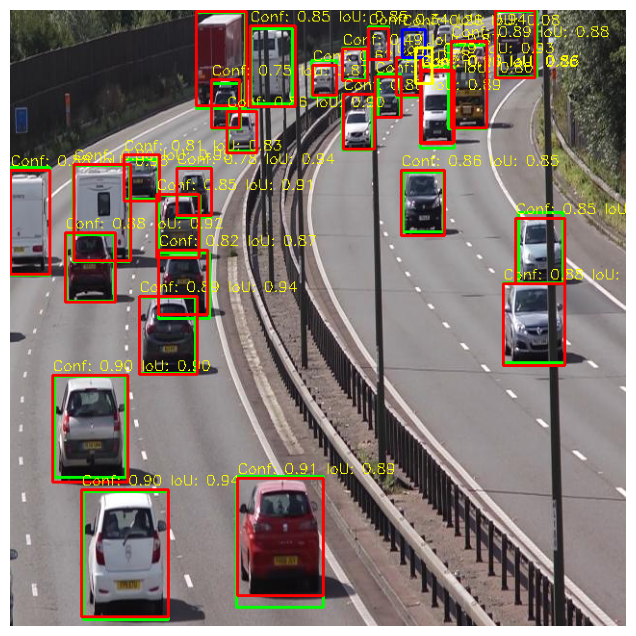

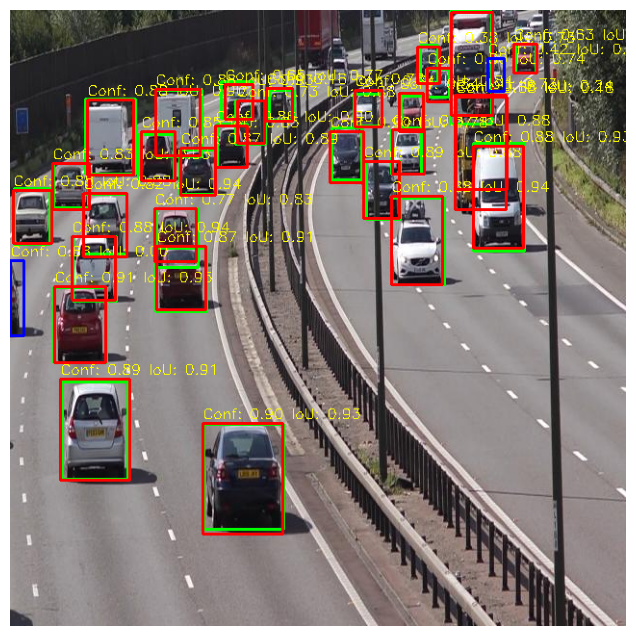

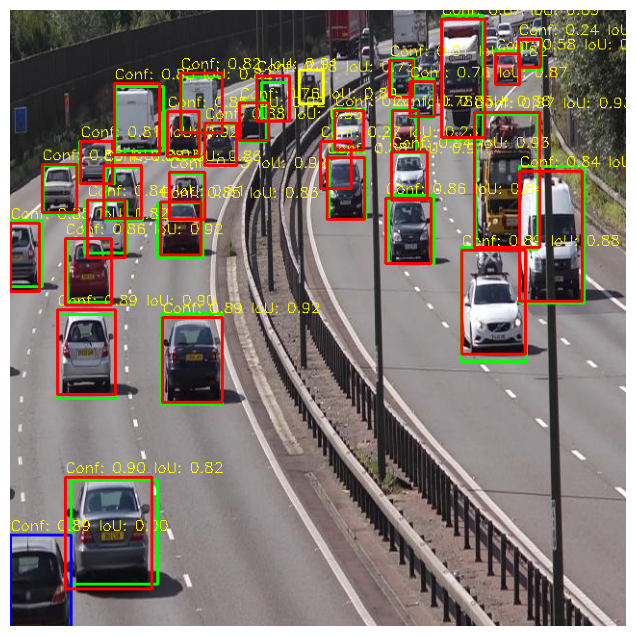

GT counts per image: [24, 21, 28, 28, 31, 29, 33, 25, 23, 23, 13, 11, 11, 10, 14, 14, 2, 4, 4, 3, 3, 5, 7, 7, 6, 6, 8, 4, 7, 2, 6, 9, 5, 2, 2, 5, 11, 5, 4, 3, 4, 5, 4, 1, 1, 4, 2, 12, 14, 13, 17, 16, 14, 16, 22, 21, 4, 1, 3, 3, 3, 2, 1, 1, 3, 4, 2, 5, 4, 7, 10, 11, 13, 15, 19, 9, 14, 11, 16, 19, 18, 17, 19, 7, 6, 4, 17, 11, 19, 15]
Pred counts per image: [23, 23, 28, 30, 31, 30, 33, 28, 26, 24, 13, 11, 11, 10, 14, 14, 2, 3, 3, 3, 3, 5, 7, 7, 6, 6, 8, 4, 8, 2, 6, 8, 5, 2, 3, 5, 12, 5, 3, 3, 2, 6, 3, 1, 1, 4, 2, 10, 14, 13, 15, 16, 14, 16, 19, 20, 3, 1, 4, 3, 3, 2, 1, 1, 3, 4, 1, 5, 4, 8, 11, 14, 14, 17, 21, 9, 14, 11, 15, 18, 18, 15, 17, 7, 5, 4, 16, 12, 19, 15]
Extra pred counts per image: [1, 6, 1, 2, 1, 2, 1, 5, 7, 2, 0, 1, 2, 2, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 2, 2, 4, 3, 0, 2, 2, 0, 0, 2, 1, 1, 2, 0, 2, 0, 0, 0, 0, 0, 2, 5, 1, 4, 2, 5, 2, 2, 3, 0, 1, 0, 0, 1, 0, 1, 3, 3, 0, 0, 2, 0, 5, 8, 6, 4, 5, 4, 5, 6, 9, 5, 3, 1, 1, 4, 1, 1, 0, 2, 4, 5, 3]
Missed GT counts per image: [1

In [41]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import glob
import os

img_folder = "/kaggle/input/traffic-dataset/traffic_wala_dataset/valid/images"
gt_folder = "/kaggle/working/val_for_map_txt"
pred_folder = "/kaggle/working/softnms_outputs_txt"

img_files = sorted(glob.glob(f"{img_folder}/*.jpg"))
gt_files = sorted(glob.glob(f"{gt_folder}/*.txt"))
pred_files = sorted(glob.glob(f"{pred_folder}/*.txt"))

def yolo_to_xyxy(box, w, h):
    cx, cy, bw, bh = box
    x1 = int((cx - bw / 2) * w)
    y1 = int((cy - bh / 2) * h)
    x2 = int((cx + bw / 2) * w)
    y2 = int((cy + bh / 2) * h)
    return [x1, y1, x2, y2]

def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea + 1e-6)
    return iou

val_count = []
pred_count = []
pred_extra = []
missed_gt_count = []
n=0
for img_path, gt_path, pred_path in zip(img_files, gt_files, pred_files):
    n+=1
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    gt_data = np.loadtxt(gt_path).reshape(-1, 5)
    gt_boxes = []
    for row in gt_data:
        _, cx, cy, bw, bh = row
        box = yolo_to_xyxy((cx, cy, bw, bh), w, h)
        gt_boxes.append(box)
        cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)  # green for ground truth

    val_count.append(len(gt_boxes))
    pred_boxes = []
    if os.path.getsize(pred_path) > 0:
        pred_data = np.loadtxt(pred_path).reshape(-1, 6)
        boxes_pred = 0
        boxes_extra = 0
        for row in pred_data:
            _, cx, cy, bw, bh, conf = row
            box = yolo_to_xyxy((cx, cy, bw, bh), w, h)
            pred_boxes.append(box)
            best_iou = 0
            for gt_box in gt_boxes:
                iou = compute_iou(box, gt_box)
                best_iou = max(best_iou, iou)
            if best_iou < 0.09:
                boxes_extra += 1
                cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), (0, 0, 255), 2)  # blue for extra
            else:
                boxes_pred += 1
                cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2)  # red for pred

            cv2.putText(img, f"Conf: {conf:.2f} IoU: {best_iou:.2f}",
                        (box[0], box[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        (255, 255, 0), 1)

        pred_count.append(boxes_pred)
        pred_extra.append(boxes_extra)
    else:
        pred_count.append(0)
        pred_extra.append(0)
    missed = 0
    for gt_box in gt_boxes:
        matched = False
        for pred_box in pred_boxes:
            iou = compute_iou(gt_box, pred_box)
            if iou >= 0.5:
                matched = True
                break
        if not matched:
            missed += 1
            cv2.rectangle(img, (gt_box[0], gt_box[1]), (gt_box[2], gt_box[3]), (255, 255, 0), 2)  # yellow for missed ground truth

    missed_gt_count.append(missed)

    if n<6 and n>2:
        plt.figure(figsize=(10, 8))
        plt.imshow(img)
        plt.axis('off')
        plt.show()

print("GT counts per image:", val_count)
print("Pred counts per image:", pred_count)
print("Extra pred counts per image:", pred_extra)
print("Missed GT counts per image:", missed_gt_count)
print("Total missed GT boxes:", np.sum(missed_gt_count))
print("Average missed GT boxes per image:", np.mean(missed_gt_count))

**MAE AND VISUALIZATION OF VEHICLE COUNT EXLUDING EXTRA CORRECTLY PREDICTED BOXES**

RMSE
RMSE: 1.0327955589886444
Percentage RMSE error: 9.920128101278335 %
90.07987189872168
MAE
mae: 0.6
percentage_mae_error 5.763073639274279
94.23692636072573
average extra count 0.19316969050160088
missed gt boxes: [1, 0, 1, 0, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 1, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 1, 3, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 3, 2, 0, 1, 0, 2, 0, 0, 0]
Average recall per image: 96.05122732123799


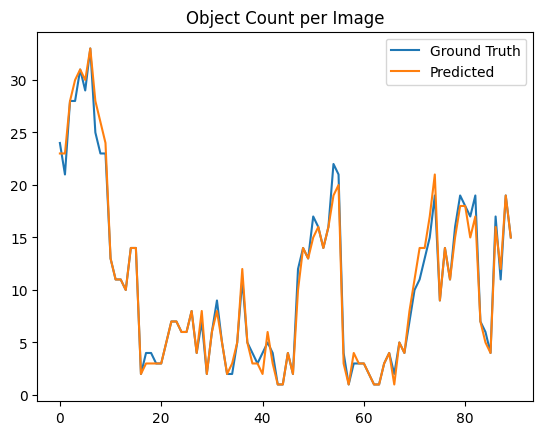

In [45]:
print("RMSE")
val_count_arr=np.array(val_count)
pred_count_arr=np.array(pred_count)
pred_count_extra=np.array(pred_extra)
avg_gt = np.mean(val_count_arr)
rmse= np.sqrt(np.mean(np.power((val_count_arr - pred_count_arr), 2)))
print("RMSE:", rmse)
percentage_error = (rmse / avg_gt) * 100
print("Percentage RMSE error:", percentage_error, "%")
print(((avg_gt-rmse)/avg_gt)*100)

print("MAE")
mae = np.mean(np.abs(pred_count_arr - val_count_arr))
print("mae:",mae)
percentage_mae_error = (mae / avg_gt) * 100
print("percentage_mae_error",percentage_mae_error)
print(((avg_gt-mae)/avg_gt)*100)

print("average extra count",np.mean(pred_extra/avg_gt))

print("missed gt boxes:",missed_gt_count)
print("Average recall per image:",((avg_gt-np.mean(missed_gt_count))/avg_gt)*100)

import matplotlib.pyplot as plt
plt.plot(val_count_arr, label='Ground Truth')
plt.plot(pred_count_arr, label='Predicted')
plt.legend()
plt.title('Object Count per Image')
plt.show()

In [149]:
# txt_file_path = "/kaggle/working/val_for_map_txt/10_mp4-0_jpg.rf.08b3bd34bbb73fb80c2d662c34474a98.txt"

# with open(txt_file_path, "r") as f:
#     content = f.read()

# print(content)

In [150]:
# print("GT box example:", gt_boxes[1:5])
# print("Pred box example:", pred_boxes[1:5])

In [151]:
# import os
# import glob

# gt_folder = "/kaggle/input/traffic-dataset/traffic_wala_dataset/valid/labels"
# pred_folder = "/kaggle/working/softnms_outputs_txt"

# gt_files = sorted(glob.glob(os.path.join(gt_folder, "*.txt")))
# pred_files = sorted(glob.glob(os.path.join(pred_folder, "*.txt")))

# val_counts = []
# pred_counts = []

# for gt_file, pred_file in zip(gt_files, pred_files):
#     with open(gt_file, "r") as f_gt:
#         gt_lines = f_gt.readlines()
#         val_counts.append(len(gt_lines))

#     with open(pred_file, "r") as f_pred:
#         pred_lines = f_pred.readlines()
#         pred_counts.append(len(pred_lines))

# print("GT (val) box counts per file:", val_counts)
# print(len(val_counts))
# print("Predicted box counts per file:", pred_counts)
# print(len(pred_counts))

In [ ]:
!cp runs/detect/run-1/weights/best.pt /kaggle/outputs/best.pt

In [154]:
############################################  VIDEO   ####################################################

In [52]:
import numpy as np

def soft_nms_video(boxes, scores, sigma=0.2, Nt=0.05, threshold=0.5, method='gaussian'):
    N = boxes.shape[0]
    indexes = np.arange(N)
    for i in range(N):
        maxscore = scores[i]
        maxpos = i
        for pos in range(i+1, N):
            if scores[pos] > maxscore:
                maxscore = scores[pos]
                maxpos = pos
        boxes[[i, maxpos]] = boxes[[maxpos, i]]
        scores[[i, maxpos]] = scores[[maxpos, i]]
        indexes[[i, maxpos]] = indexes[[maxpos, i]]

        boxA = boxes[i]
        for j in range(i+1, N):
            boxB = boxes[j]
            xx1 = max(boxA[0], boxB[0])
            yy1 = max(boxA[1], boxB[1])
            xx2 = min(boxA[2], boxB[2])
            yy2 = min(boxA[3], boxB[3])
            w = max(0., xx2 - xx1 + 1)
            h = max(0., yy2 - yy1 + 1)
            inter = w * h
            areaA = (boxA[2]-boxA[0]+1)*(boxA[3]-boxA[1]+1)
            areaB = (boxB[2]-boxB[0]+1)*(boxB[3]-boxB[1]+1)
            ovr = inter / (areaA + areaB - inter)
            if method == 'linear':
                if ovr > Nt:
                    scores[j] = scores[j] * (1 - ovr)
            elif method == 'gaussian':
                scores[j] = scores[j] * np.exp(- (ovr**2) / sigma)
            else:
                if ovr > Nt:
                    scores[j] = 0
    keep = scores > threshold
    return boxes[keep], scores[keep], indexes[keep]

In [54]:
model = YOLO("/kaggle/input/best-weights/best.pt")
video_path = "/kaggle/input/test-video/traffic_aims_required.mp4"
cap = cv2.VideoCapture(video_path)

fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"🎥 FPS: {fps}, Size: {width}x{height}, Total frames: {total_frames}")

out = cv2.VideoWriter("video_yolo_softnms_final.mp4",
                      cv2.VideoWriter_fourcc(*'mp4v'),
                      fps, (width, height))

frame_num = 0
vehicle_counts = []
window = 5
line_y = int(height * 0.8)
offset = 20
counted_ids = set()
global_count = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    results = model.track(frame, persist=True, conf=0.1, verbose=False,iou=0.65)
    boxes_obj = results[0].boxes

    if boxes_obj is not None:
        xyxy = boxes_obj.xyxy.cpu().numpy()
        conf = boxes_obj.conf.cpu().numpy()
        ids = boxes_obj.id.cpu().numpy() if boxes_obj.id is not None else np.arange(len(xyxy))

        soft_boxes, soft_scores, soft_indexes = soft_nms_video(xyxy, conf, sigma=0.5, Nt=0.1, threshold=0.15, method='gaussian')

        num_vehicles = len(soft_boxes)
        vehicle_counts.append(num_vehicles)
        if len(vehicle_counts) > window:
            vehicle_counts.pop(0)
        smooth_count = int(sum(vehicle_counts) / len(vehicle_counts))

        annotated_frame = frame.copy()
        for i, box in enumerate(soft_boxes):
            x1, y1, x2, y2 = box.astype(int)
            cv2.rectangle(annotated_frame, (x1,y1), (x2,y2), (0,255,0), 2)
            obj_id = int(ids[soft_indexes[i]])
            cx, cy = (x1 + x2)//2, (y1 + y2)//2
            cv2.circle(annotated_frame, (cx, cy), 5, (0,0,255), -1)
            cv2.putText(annotated_frame, str(obj_id), (cx, cy - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)

            if abs(cy - line_y) < offset and obj_id not in counted_ids:
                counted_ids.add(obj_id)
                global_count += 1
    else:
        annotated_frame = frame.copy()
        vehicle_counts.append(0)
        if len(vehicle_counts) > window:
            vehicle_counts.pop(0)
        smooth_count = int(sum(vehicle_counts) / len(vehicle_counts))

    cv2.line(annotated_frame, (0, line_y), (width, line_y), (255, 0, 255), 2)

    cv2.putText(annotated_frame, f"Vehicles : {smooth_count}", (20, 50),
                cv2.FONT_HERSHEY_SCRIPT_SIMPLEX, 1.2, (180, 105, 255), 3)
    cv2.putText(annotated_frame, f"Global Count: {global_count}", (20, 100),
                cv2.FONT_HERSHEY_SIMPLEX, 1.2, (150, 80, 255), 3)

    out.write(annotated_frame)
    frame_num += 1

cap.release()
out.release()



🎥 FPS: 30.0, Size: 1280x720, Total frames: 900
